
# Failure of Machine Learning to infer causal effects

Machine Learning models are great for measuring statistical associations.
Unfortunately, unless we're willing to make strong assumptions about the data,
those models are unable to infer causal effects.

To illustrate this, we will simulate a situation in which we try to answer one
of the most important questions in economics of education: **what is the causal
effect of earning a college degree on hourly wages?** Although the answer to
this question is crucial to policy makers, [Omitted-Variable Biases](https://en.wikipedia.org/wiki/Omitted-variable_bias) (OVB) prevent us from
identifying that causal effect.


## The dataset: simulated hourly wages

The data generating process is laid out in the code below. Work experience in
years and a measure of ability are drawn from Normal distributions; the
hourly wage of one of the parents is drawn from Beta distribution. We then
create an indicator of college degree which is positively impacted by ability
and parental hourly wage. Finally, we model hourly wages as a linear function
of all the previous variables and a random component. Note that all variables
have a positive effect on hourly wages.



In [1]:
import numpy as np
import pandas as pd

n_samples = 10_000
rng = np.random.RandomState(32)

experiences = rng.normal(20, 10, size=n_samples).astype(int)
experiences[experiences < 0] = 0
abilities = rng.normal(0, 0.15, size=n_samples)
parent_hourly_wages = 50 * rng.beta(2, 8, size=n_samples)
parent_hourly_wages[parent_hourly_wages < 0] = 0
college_degrees = (
    9 * abilities + 0.02 * parent_hourly_wages + rng.randn(n_samples) > 0.7
).astype(int)

true_coef = pd.Series(
    {
        "college degree": 2.0,
        "ability": 5.0,
        "experience": 0.2,
        "parent hourly wage": 1.0,
    }
)
hourly_wages = (
    true_coef["experience"] * experiences
    + true_coef["parent hourly wage"] * parent_hourly_wages
    + true_coef["college degree"] * college_degrees
    + true_coef["ability"] * abilities
    + rng.normal(0, 1, size=n_samples)
)

hourly_wages[hourly_wages < 0] = 0

In [2]:
hourly_wages

array([13.09522702, 10.48904851, 11.72800228, ..., 15.8248059 ,
       24.93891551,  7.3046709 ])

## Description of the simulated data

The following plot shows the distribution of each variable, and pairwise
scatter plots. Key to our OVB story is the positive relationship between
ability and college degree.



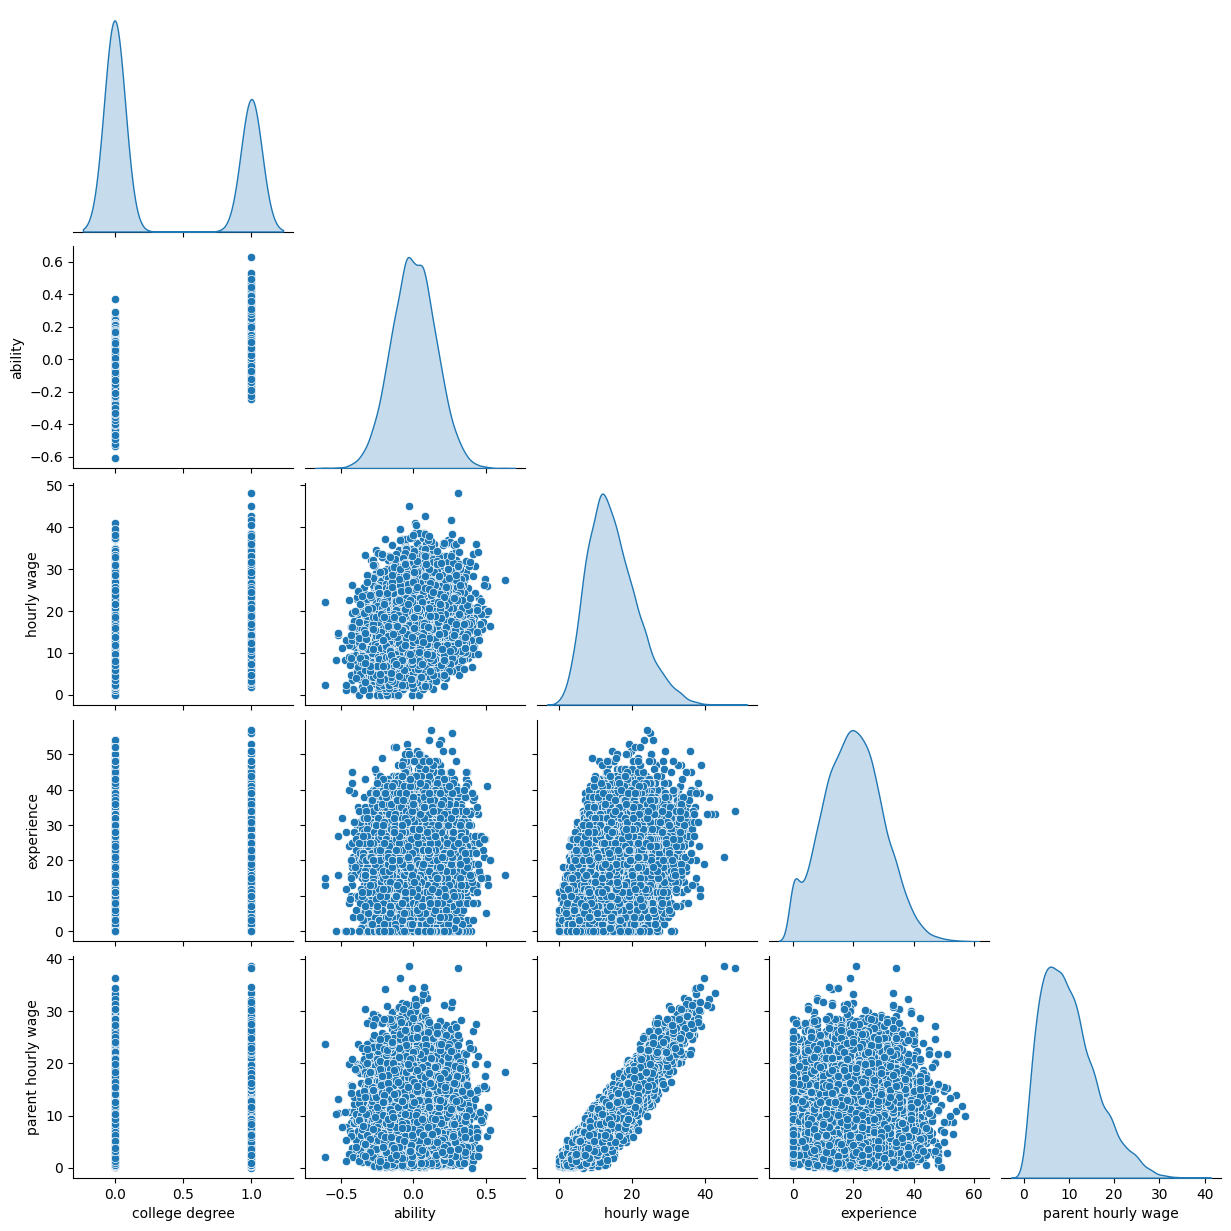

In [3]:
import seaborn as sns

df = pd.DataFrame(
    {
        "college degree": college_degrees,
        "ability": abilities,
        "hourly wage": hourly_wages,
        "experience": experiences,
        "parent hourly wage": parent_hourly_wages,
    }
)

grid = sns.pairplot(df, diag_kind="kde", corner=True)

In the next section, we train predictive models and we therefore split the
target column from over features and we split the data into a training and a
testing set.



In [4]:
from sklearn.model_selection import train_test_split

target_name = "hourly wage"
X, y = df.drop(columns=target_name), df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Income prediction with fully observed variables

First, we train a predictive model, a
:class:`~sklearn.linear_model.LinearRegression` model. In this experiment,
we assume that all variables used by the true generative model are available.



In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from time import time 
tic = time()
features_names = ["experience", "parent hourly wage", "college degree", "ability"]

regressor_with_ability = LinearRegression()
regressor_with_ability.fit(X_train[features_names], y_train)
y_pred_with_ability = regressor_with_ability.predict(X_test[features_names])
R2_with_ability = r2_score(y_test, y_pred_with_ability)

print(f"R2 score with ability: {R2_with_ability:.3f}")
print(f" took {time() - tic :.3f} sec ")

R2 score with ability: 0.975
 took 0.007 sec 


This model predicts well the hourly wages as shown by the high R2 score. We
plot the model coefficients to show that we exactly recover the values of
the true generative model.



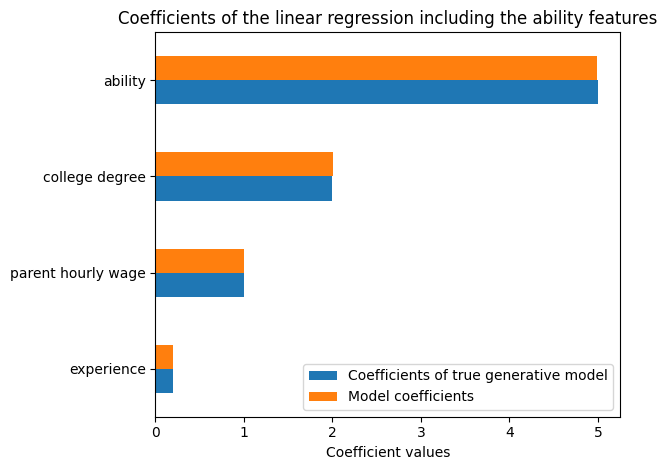

In [9]:
import matplotlib.pyplot as plt

model_coef = pd.Series(regressor_with_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
ax.set_title("Coefficients of the linear regression including the ability features")
_ = plt.tight_layout()

## Income prediction with partial observations

In practice, intellectual abilities are not observed or are only estimated
from proxies that inadvertently measure education as well (e.g. by IQ tests).
But omitting the "ability" feature from a linear model inflates the estimate
via a positive OVB.



In [10]:
features_names = ["experience", "parent hourly wage", "college degree"]

regressor_without_ability = LinearRegression()
regressor_without_ability.fit(X_train[features_names], y_train)
y_pred_without_ability = regressor_without_ability.predict(X_test[features_names])
R2_without_ability = r2_score(y_test, y_pred_without_ability)

print(f"R2 score without ability: {R2_without_ability:.3f}")

R2 score without ability: 0.968


The predictive power of our model is similar when we omit the ability feature
in terms of R2 score. We now check if the coefficient of the model are
different from the true generative model.



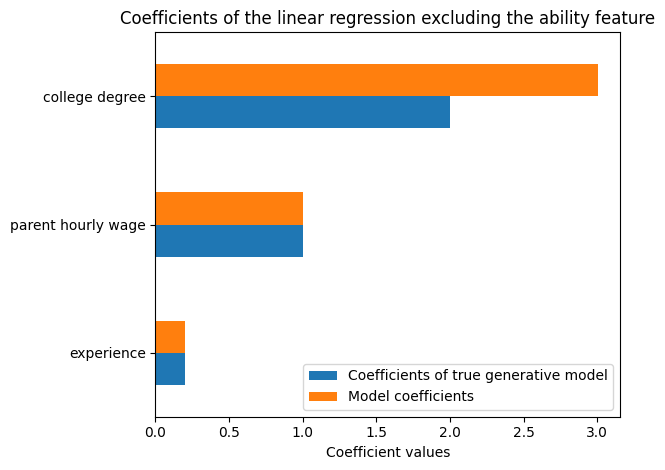

In [12]:
model_coef = pd.Series(regressor_without_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
_ = ax.set_title("Coefficients of the linear regression excluding the ability feature")
plt.tight_layout()
plt.show()

To compensate for the omitted variable, the model inflates the coefficient of
the college degree feature. Therefore, interpreting this coefficient value
as a causal effect of the true generative model is incorrect.

## Lessons learned

Machine learning models are not designed for the estimation of causal
effects. While we showed this with a linear model, OVB can affect any type of
model.

Whenever interpreting a coefficient or a change in predictions brought about
by a change in one of the features, it is important to keep in mind
potentially unobserved variables that could be correlated with both the
feature in question and the target variable. Such variables are called
[Confounding Variables](https://en.wikipedia.org/wiki/Confounding). In
order to still estimate causal effect in the presence of confounding,
researchers usually conduct experiments in which the treatment variable (e.g.
college degree) is randomized. When an experiment is prohibitively expensive
or unethical, researchers can sometimes use other causal inference techniques
such as [Instrumental Variables](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) (IV)
estimations.

